In [1]:
# 载入标注文件
import json
with open('F:/study/0_Project/sea_detection/2020dataset/VOC2007/VOCdevkit/VOC2007/cocoformatJson/voc_2007_all.json') as f:
    a=json.load(f)
with open(r'F:\study\0_Project\sea_detection\mmdet_luo\data\train_new.json') as g:
    train=json.load(g)  
with open(r'F:\study\0_Project\sea_detection\mmdet_luo\data\val_new.json') as h:
    val=json.load(h)

In [4]:
print('标签类别')
print('类别数量:' ,len(a['categories']))
a['categories']

标签类别
类别数量: 4


[{'supercategory': 'holothurian', 'id': 1, 'name': 'holothurian'},
 {'supercategory': 'echinus', 'id': 2, 'name': 'echinus'},
 {'supercategory': 'scallop', 'id': 3, 'name': 'scallop'},
 {'supercategory': 'starfish', 'id': 4, 'name': 'starfish'}]

In [5]:
print('训练集图片数量：', len(a['images']))
print('训练集标签数量：', len(a['annotations']))

训练集图片数量： 5543
训练集标签数量： 41441


In [6]:
total=[]
for img in a['images']:
    wh=(img['width'], img['height'])
    total.append(wh)
unique=set(total)
for k in unique:
    print('长宽为(%d.%d)的图片数量为：'%k,total.count(k))
# 可以看出 图像的分辨率不是固定的  (720,405)的图像相对较多，其次是(3840,2160)

长宽为(704.576)的图片数量为： 38
长宽为(1920.1080)的图片数量为： 596
长宽为(3840.2160)的图片数量为： 1712
长宽为(720.405)的图片数量为： 3153
长宽为(586.480)的图片数量为： 44


In [7]:
ids=[]
images_id=[]
for i in a['annotations']:
    ids.append(i['id'])
    images_id.append(i['image_id'])
print('训练集图片数量: ', 5543)
print('unique id 数量: ', len(set(ids)))
print('unique image_id 数量: ', len(set(images_id)))

训练集图片数量:  5543
unique id 数量:  41441
unique image_id 数量:  5455


In [8]:
image_list = set(images_id)
import os
tmp = os.listdir(r'F:\study\0_Project\sea_detection\2020dataset\VOC2007\VOCdevkit\VOC2007\JPEGImages')
os_list = [int(i.replace('.jpg','')) for i in tmp]
org_list = set(os_list)
gaps = org_list - image_list
print('缺少标注的图像数量：', len(gaps))
# gaps的元素在org_list中存在，但是在image_list中不存在,有88个文件没有标注信息，annotation为空
# 那么在训练的过程中，全图为空，没有标注的图，应该删掉，或者使用mixup，增强特征，这点后面再进行考虑
# mmdetection会自动删除全图标注为空的样本

缺少标注的图像数量： 88


In [9]:
# 查看统计量
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.family']='sans-serif'
plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [4]:
## 创建类别标签字典
category_dic = dict([(i['id'], i['name']) for i in a['categories']])
category_dic

{1: 'holothurian', 2: 'echinus', 3: 'scallop', 4: 'starfish'}

In [16]:
counts_label_all=dict([(i['name'], 0) for i in a['categories']])
counts_label_train=dict([(j['name'], 0) for j in train['categories']])
counts_label_val=dict([(h['name'], 0) for h in val['categories']])
for i in a['annotations']:
    counts_label_all[category_dic[i['category_id']]] += 1
for j in train['annotations']:  
    counts_label_train[category_dic[j['category_id']]] += 1
for n in val['annotations']:
    counts_label_val[category_dic[n['category_id']]] += 1
    
print("总数据集每个类别的标注数量： {}".format(counts_label_all))
print("train集每个类别的标注数量： {}".format(counts_label_train))
print("val集每个类别的标注数量： {}".format(counts_label_val))

总数据集每个类别的标注数量： {'holothurian': 5537, 'echinus': 22343, 'scallop': 6720, 'starfish': 6841}
train集每个类别的标注数量： {'holothurian': 4574, 'echinus': 18676, 'scallop': 5554, 'starfish': 5704}
val集每个类别的标注数量： {'holothurian': 963, 'echinus': 3667, 'scallop': 1166, 'starfish': 1137}


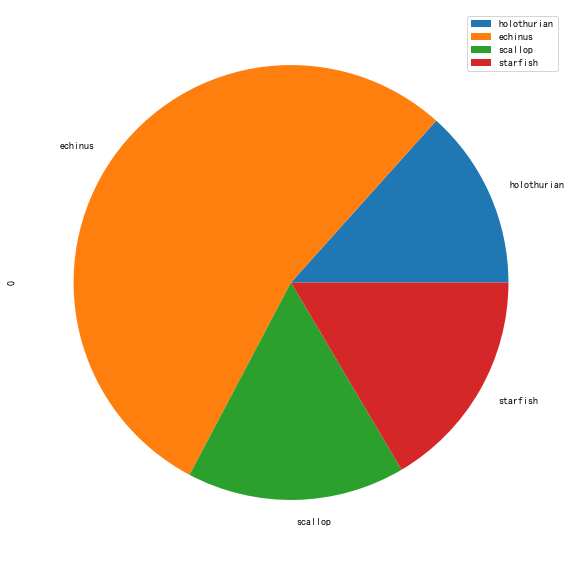

In [12]:
# 打印
%matplotlib inline 
plt.style.use({'figure.figsize':(10, 10)})
indexs=counts_label.keys()
values=counts_label.values()
Count_df=pd.DataFrame(list(values),index=indexs)
Count_df.plot(kind='pie',y=Count_df.columns)


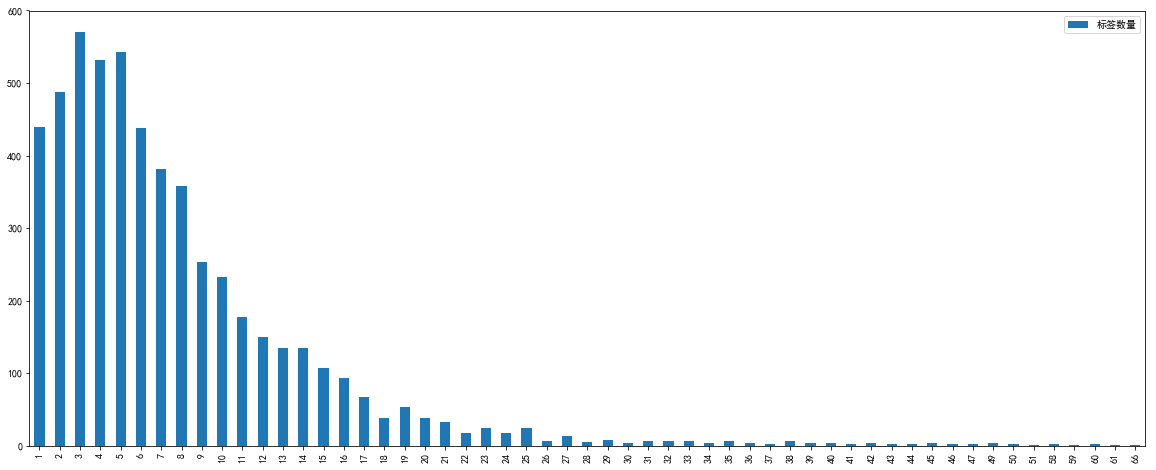

In [13]:
# 存在相同标签数量的图的数量的统计直方图
%matplotlib inline
plt.style.use({'figure.figsize':(20, 8)})
annoto_count={}
for i in a['annotations']:
    annoto_count[i['image_id']]=annoto_count.setdefault(i['image_id'],0)+1
indes_list=set(annoto_count.values())
indes_list
values_count=[list(annoto_count.values()).count(i) for i in indes_list]
pd.DataFrame(values_count,index=indes_list,columns=['标签数量']).plot(kind='bar')
# 有1个标注的图的数量有440张
# 有3个标注的图的数量有580张

In [14]:
# 剔除冗余信息
anntotations =[]
for i in a['annotations']:
    an=i
    an.pop('id')  # anns的标注id
    an.pop('iscrowd')
    anntotations.append(an)

In [15]:
# 将标签于对应图片合并起来，形成新的数据格式
data = []
per_sample = {}
for img in a['images']:
    sample_img = img
    annota_list = [] # 保存该图片对应的标签
    for per in anntotations:
        if per['image_id']==img['id']:   # 将一张图的所有的ann装进annota_list中
            annota_list.append(per)
    for k in annota_list:
        anntotations.remove(k)   # 把拿出来的ann在总的标注文件中都删除掉
    sample_img['annotations'] = annota_list
    data.append(sample_img)

In [16]:
# 定义一个画图函数
from PIL import Image, ImageFont, ImageDraw
import numpy as np
import colorsys
import matplotlib.pyplot as plt
def plot_imgs(img_data,gap=10,path=''):
    files_name=img_data['file_name']
    img_annotations=img_data['annotations']
    n=len(img_annotations)
    boxs=np.zeros((n,4))
    tag=[]
    img=Image.open('F:/study/0_Project/sea_detection/2020dataset/VOC2007/VOCdevkit/VOC2007/JPEGImages/'+files_name) # 图片路径
    img_w=img.size[0]
    img_h=img.size[1]
    for i in range(n):
        bbox=img_annotations[i]['bbox']
        tag.append(category_dic[img_annotations[i]['category_id']])
        y1 = max(0, np.floor(bbox[1] + 0.5).astype('int32'))
        x1 = max(0, np.floor(bbox[0] + 0.5).astype('int32'))
        y2 = min(img_h, np.floor(bbox[1]+bbox[3] + 0.5).astype('int32'))
        x2= min(img_w, np.floor(bbox[0]+bbox[2] + 0.5).astype('int32'))
        boxs[i]=[x1,y1,x2,y2]

    
    font = ImageFont.truetype(font="simsun.ttc",size=np.floor(3.5e-2 * img_w).astype('int32'),encoding="unic")
    hsv_tuples = [(x / n, 1., 1.)for x in range(n)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                    colors))
    for index in range(len(boxs)):
        draw = ImageDraw.Draw(img)
        label_size = draw.textsize(tag[index], font)
        text_origin = np.array([20,25+index*label_size[1]])
        for i in range(gap):
            draw.rectangle(
            [boxs[index][0] + i, boxs[index][1] + i, boxs[index][2] - i, boxs[index][3] - i],outline=colors[index])
    #     draw.rectangle(list(),outline=colors[index])
        draw.rectangle( [tuple(text_origin), tuple(text_origin + label_size)], fill=colors[index])
        draw.text(text_origin,tag[index], fill=(0, 0, 0), font=font)
    %matplotlib inline
    plt.style.use({'figure.figsize':(20, 10)})
    plt.imshow(img)

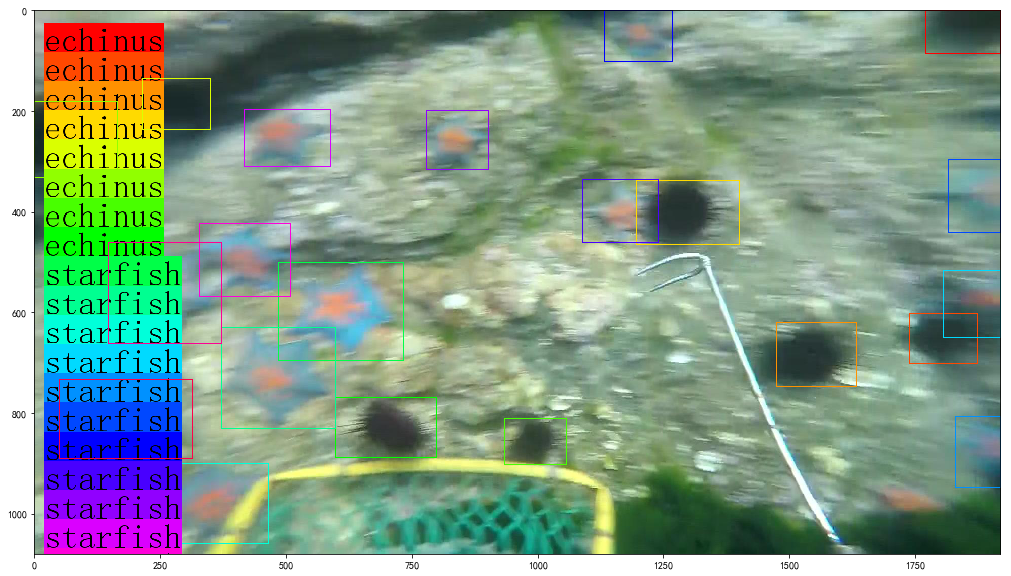

In [17]:
for d in data:
    if len(d['annotations'])==21:
        break
plot_imgs(d,gap=2,path='') 

宽高比1.0: 数量:34039
宽高比2.0: 数量:6585
宽高比3.0: 数量:717
宽高比4.0: 数量:82
宽高比5.0: 数量:12
宽高比6.0: 数量:2
宽高比7.0: 数量:3
宽高比21.0: 数量:1


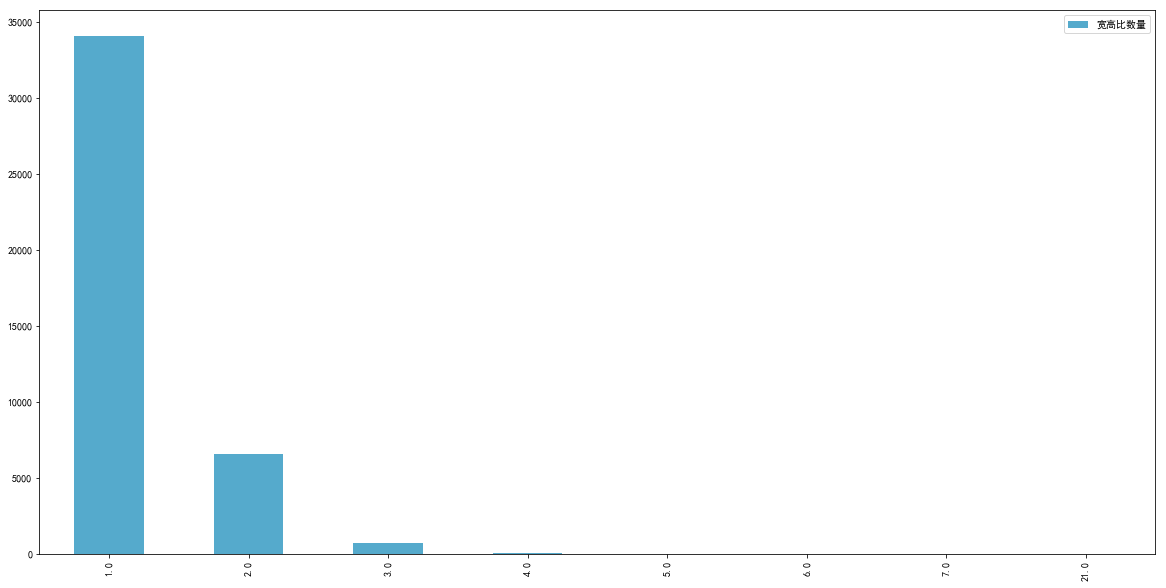

In [18]:
# 对所有标注长宽做统计
total_size=[]
total_height=[]
total_wh=[]

for im in data:                     # 每张图的信息
    for b in im['annotations']:     # 每张图的每个标注
        # total_width += [b['bbox'][2]]
        # total_height += [b['bbox'][3]]
        wh = round(b['bbox'][2]/b['bbox'][3], 0)
        if wh < 1 :
            wh = round(b['bbox'][3]/b['bbox'][2],0)
        total_wh += [wh]

# 所有标签的长宽高比例
box_wh_unique = list(set(total_wh))
box_wh_count=[total_wh.count(i) for i in box_wh_unique]

bbox_wh_dict = {}
for i, key in enumerate(box_wh_unique):
    print('宽高比{}: 数量:{}'.format(key, box_wh_count[i]))

# 绘图
wh_df = pd.DataFrame(box_wh_count,index=box_wh_unique,columns=['宽高比数量'])
wh_df.plot(kind='bar',color="#55aacc")
plt.show()

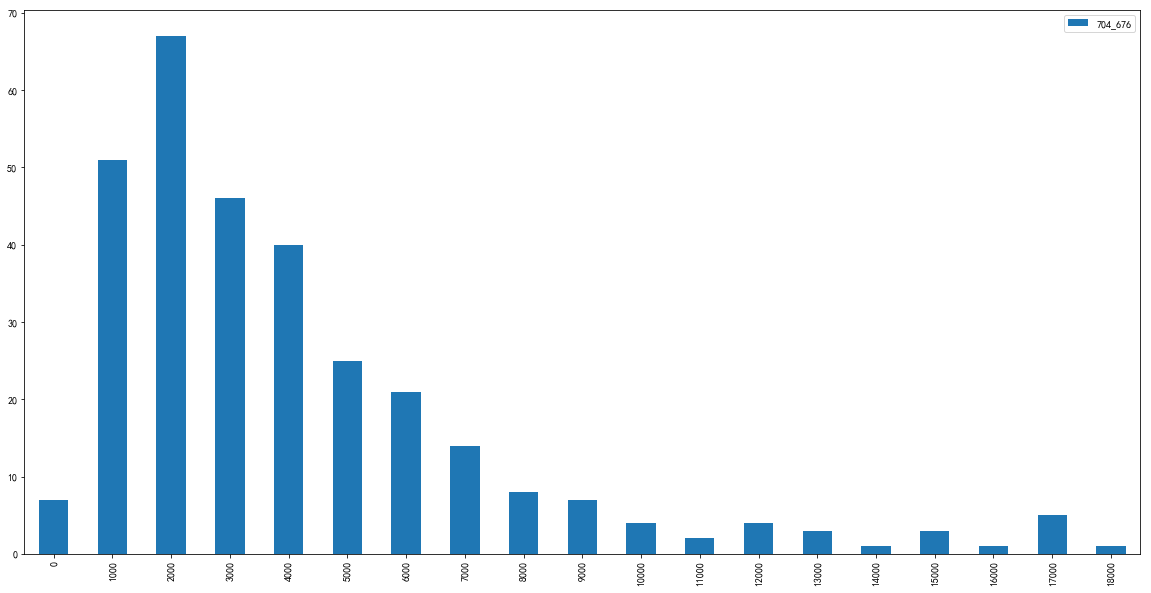

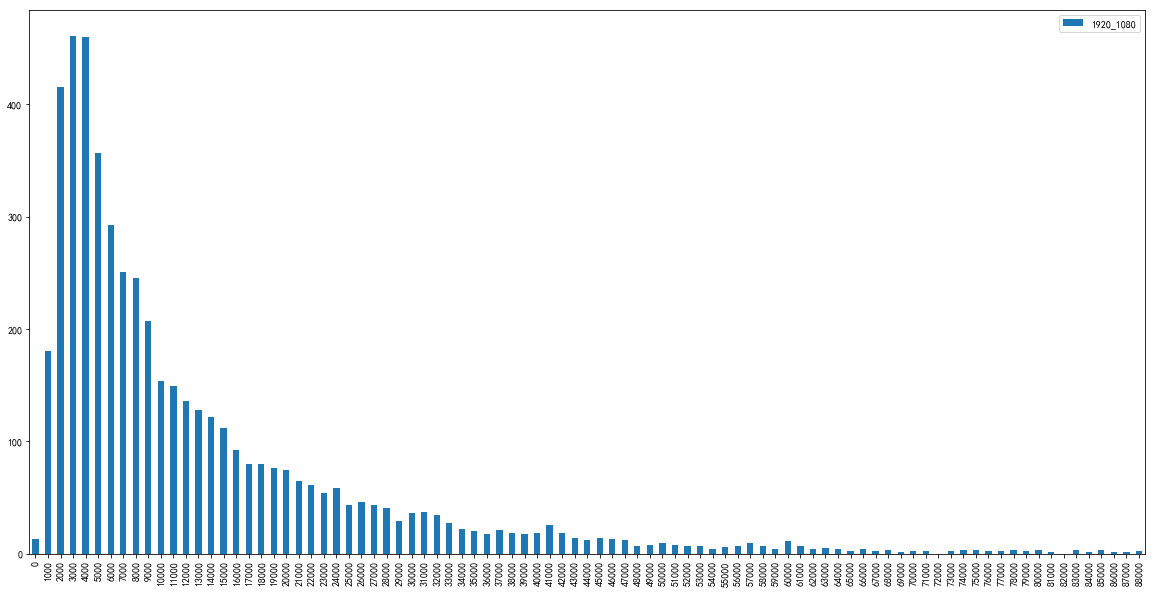

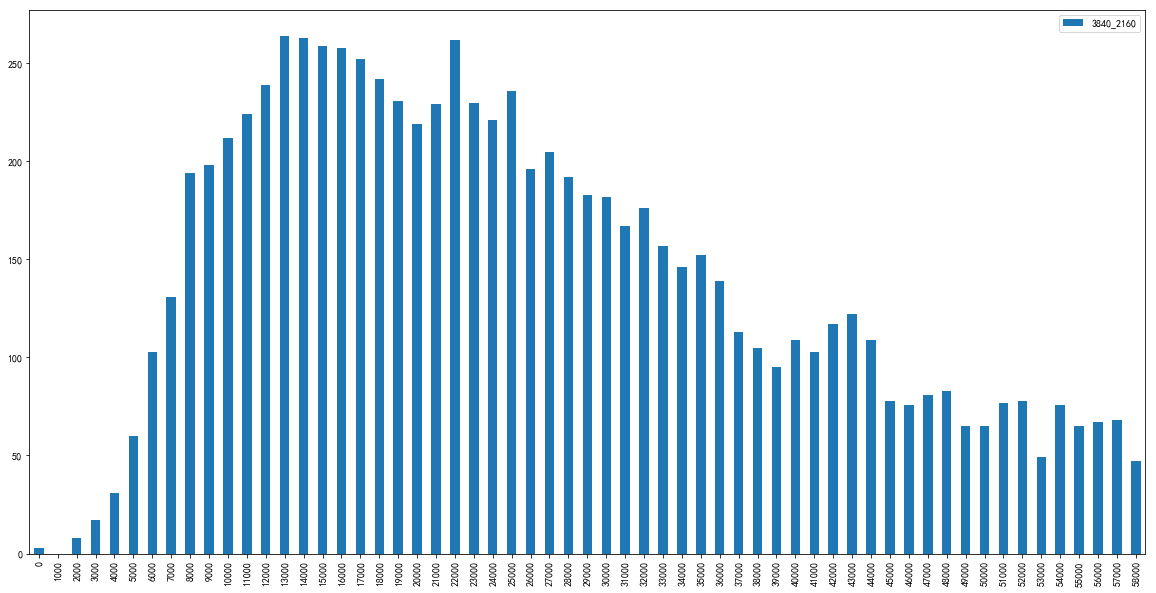

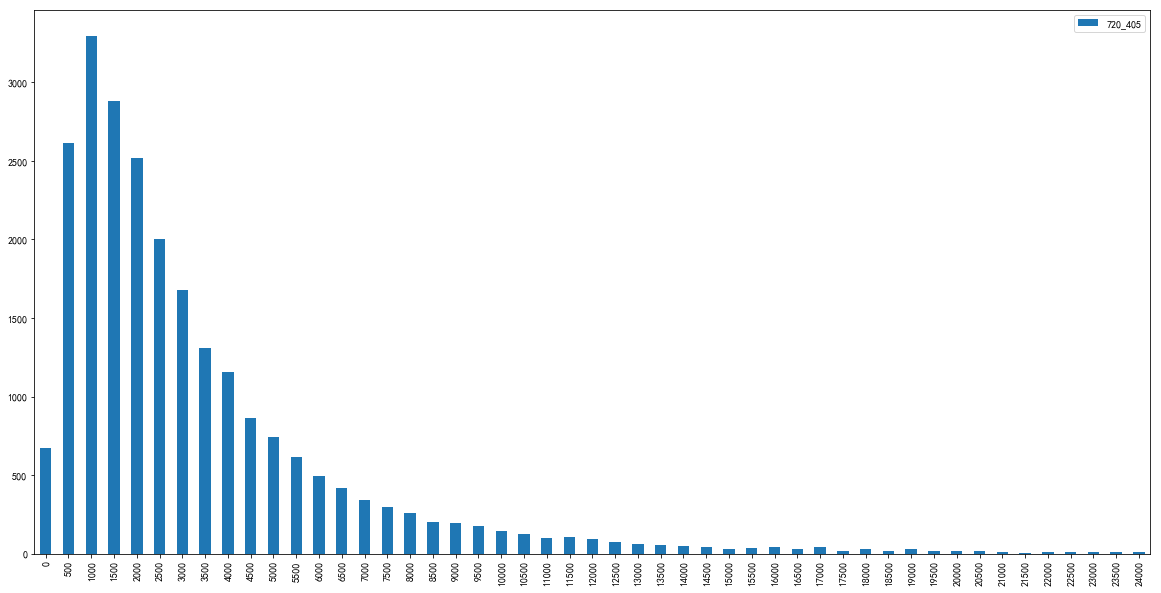

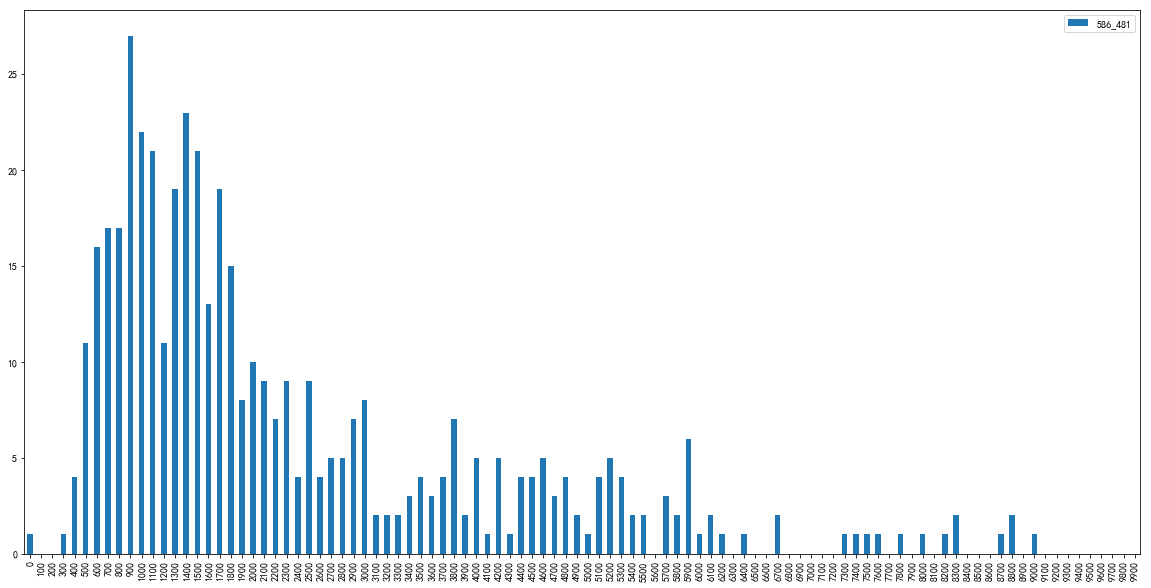

In [19]:
# 对所有标注面积比做统计
total_size704_676=[]
total_size1920_1080=[]
total_size3840_2160=[]
total_size720_405=[]
total_size586_481=[]

total_wh=[]

for im in data:                     # 每张图的信息
    for b in im['annotations']:     # 每张图的每个标注
        if (im['width'], im['height']) == list(unique)[0]:
            size = round(b['bbox'][2] * b['bbox'][3])
            total_size704_676 += [size]
        elif (im['width'], im['height']) == list(unique)[1]:
            size = round(b['bbox'][2] * b['bbox'][3])
            total_size1920_1080 += [size]
        elif (im['width'], im['height']) == list(unique)[2]:
            size = round(b['bbox'][2] * b['bbox'][3])
            total_size3840_2160 += [size]
        elif (im['width'], im['height']) == list(unique)[3]:
            size = round(b['bbox'][2] * b['bbox'][3])
            total_size720_405 += [size]
        elif (im['width'], im['height']) == list(unique)[4]:
            size = round(b['bbox'][2] * b['bbox'][3])
            total_size586_481 += [size]


max_size = max(total_size704_676)
gap = 1000
group_names = list(range(0,20000,gap))
size_cuts = pd.cut(total_size704_676,bins=group_names,labels=group_names[:-1])
total_df=pd.DataFrame({'704_676':size_cuts.value_counts()})
total_df.plot(kind='bar')

max_size = max(total_size1920_1080)
gap = 1000
group_names = list(range(0,90000,gap))
size_cuts = pd.cut(total_size1920_1080,bins=group_names,labels=group_names[:-1])
total_df=pd.DataFrame({'1920_1080':size_cuts.value_counts()})
total_df.plot(kind='bar')

max_size = max(total_size3840_2160)
gap = 1000
group_names = list(range(0,60000,gap))
size_cuts = pd.cut(total_size3840_2160,bins=group_names,labels=group_names[:-1])
total_df=pd.DataFrame({'3840_2160':size_cuts.value_counts()})
total_df.plot(kind='bar')

max_size = max(total_size720_405)
gap = 500
group_names = list(range(0,25000,gap))
size_cuts = pd.cut(total_size720_405,bins=group_names,labels=group_names[:-1])
total_df=pd.DataFrame({'720_405':size_cuts.value_counts()})
total_df.plot(kind='bar')

max_size = max(total_size586_481)
gap = 100
group_names = list(range(0,max_size,gap))
size_cuts = pd.cut(total_size586_481,bins=group_names,labels=group_names[:-1])
total_df=pd.DataFrame({'586_481':size_cuts.value_counts()})
total_df.plot(kind='bar')